<a href="https://colab.research.google.com/github/cjm08002/PisonChallenge/blob/main/PisonChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PISON Interview Technical Challenge**


---



# Problem Statement Summary
The task is to build a classifier of wrist movements contained in the Pison device data written to a csv file. The number of wrist movement classes is unknown. None of the data is labeled by wrist movement, suggesting an unsupervised clustering task. The csv file contains 17 columns and ~15000 rows, each row is one sample. Questions asked explicitly in the problem statement are: 


*   How many different wrist motion classes are there?
*   What is the user doing with their wrist in each whole body movement? 
*   What motion does each class represent?
*   Provide quantitative estimates of the generalization performance of your classifier






# Import packages and function definition

In [61]:
"""Import the required packages"""
import numpy as np
from sklearn import cluster
!pip install tslearn
from tslearn import metrics
from scipy import fft, signal
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files

In [62]:
""" Utilities """
def window_split(X):
    """ Splits data into prompting windows by identifying jumps in timestamp bewteen samples"""
    samples=np.arange(len(X[:,0]))
    tdiff=np.diff(X[:,0])
    end_ind=samples[0:-1][abs(tdiff)>100]
    end_ind=np.append(end_ind,samples[-1])
    start_ind=np.zeros(len(end_ind))
    start_ind[1:]=end_ind[0:-1]+1
    N=len(start_ind)
    windows=[]
    for i in range(N):
        windows.append(
            X[int(start_ind[i]):int(end_ind[i]),:]
            )
    return windows

def quat_multiply(q1,q2):
    """ Quaternion multiplication using [x,y,z,w] format """
    q3=np.array([q1[3]*q2[0]+q1[0]*q2[3]+q1[1]*q2[2]-q1[2]*q2[1],
        q1[3]*q2[1]-q1[0]*q2[2]+q1[1]*q2[3]+q1[2]*q2[0],
        q1[3]*q2[2]+q1[0]*q2[1]-q1[1]*q2[0]+q1[2]*q2[3],
        q1[3]*q2[3]-q1[0]*q2[0]-q1[1]*q2[1]-q1[2]*q2[2]])
    return q3

def window_nav(windows):
    """ Returns nav, containing a list with 15 elements, one for each window. 
    each element is a 7 element list, the first element of which contains acceleration 
    data rotated into the NEU reference frame in the first 3 columns, the final 
    6 elements are XYZ velocity and XYZ position in that order. Also plots position data 
    for 3 windows as an example """
    nav=[]
    for i in range(len(windows)):
        X_v=np.zeros(len(windows[i]))
        Y_v=np.zeros(len(windows[i]))
        Z_v=np.zeros(len(windows[i]))
        X_p=np.zeros(len(windows[i]))
        Y_p=np.zeros(len(windows[i]))
        Z_p=np.zeros(len(windows[i]))
        acc_ref=np.zeros((len(windows[i]),4))
        t_diff=np.diff(windows[i][:,0])/1000
        for ii in range(1,len(windows[i])):
            acc_temp=quat_multiply(np.array([windows[i][ii,5],windows[i][ii,6],windows[i][ii,7],windows[i][ii,8]]),np.array([windows[i][ii,12],windows[i][ii,13],windows[i][ii,14],0]))
            acc_ref[ii,:]=quat_multiply(acc_temp,np.array([-windows[i][ii,5],-windows[i][ii,6],-windows[i][ii,7],windows[i][ii,8]]))
            X_v[ii]=X_v[ii-1]+acc_ref[ii,0]*t_diff[ii-1]
            Y_v[ii]=Y_v[ii-1]+acc_ref[ii,1]*t_diff[ii-1]
            Z_v[ii]=Z_v[ii-1]+(9.82+acc_ref[ii,2])*t_diff[ii-1]
            X_p[ii]=X_p[ii-1]+X_v[ii-1]*t_diff[ii-1]
            Y_p[ii]=Y_p[ii-1]+Y_v[ii-1]*t_diff[ii-1]
            Z_p[ii]=Z_p[ii-1]+Z_v[ii-1]*t_diff[ii-1]
        nav.append([acc_ref,X_v,Y_v,Z_v,X_p,Y_p,Z_p])
    return nav   

def window_orient(windows):
    attitude_track=[]
    for i in range(len(windows)):
        window_attitude_track=np.zeros((len(windows[i][:,5]),4))
        q_inv=np.array([-windows[i][0,5],-windows[i][0,6],-windows[i][0,7],windows[i][0,8]])
        for ii in range(len(windows[i][:,5])):
            window_attitude_track[ii,:]=quat_multiply(np.array([windows[i][ii,5],windows[i][ii,6],windows[i][ii,7],windows[i][ii,8]]), q_inv)
        attitude_track.append(window_attitude_track)
    return attitude_track

def frame_trace(att_track):
    frames=[]
    for i in range(len(att_track)):
        X=np.zeros((len(att_track[i]),4))
        Y=np.zeros((len(att_track[i]),4))
        Z=np.zeros((len(att_track[i]),4))
        X[0,:]=np.array([1,0,0,0])
        Y[0,:]=np.array([0,1,0,0])    
        Z[0,:]=np.array([0,0,1,0])
        for ii in range(len(att_track[i])):
            q=att_track[i][ii,:]
            qinv=np.array([-att_track[i][ii,0],-att_track[i][ii,1],-att_track[i][ii,2],att_track[i][ii,3]])
            X[ii,:]=quat_multiply(quat_multiply(q,X[0,:]),qinv)
            Y[ii,:]=quat_multiply(quat_multiply(q,Y[0,:]),qinv)
            Z[ii,:]=quat_multiply(quat_multiply(q,Z[0,:]),qinv)
        frames.append([X,Y,Z])
    return frames

def ADCraw_dtw_matrix(windows):
    ADC_dtw=np.zeros((10,5,2))
    ADC_dtw_avg=np.zeros((10,5))
    for i in range(5,len(windows)):
        for ii in range(5):
            ADC_dtw[i-5,ii,0]=metrics.dtw(windows[ii][:,1],windows[i][:,1])
            ADC_dtw[i-5,ii,1]=metrics.dtw(windows[ii][:,2],windows[i][:,2])
            ADC_dtw_avg[i-5,ii]=np.mean([ADC_dtw[i-5,ii,0],ADC_dtw[i-5,ii,1]])
    return ADC_dtw_avg 

def ADC_dtw_matrix(windows):
    ADC_dtw=np.zeros((10,5,2))
    ADC_dtw_avg=np.zeros((10,5))
    for i in range(5,len(windows)):
        for ii in range(5):
            ADC_dtw[i-5,ii,0]=metrics.dtw(signal.medfilt(windows[ii][:,3],101),signal.medfilt(windows[i][:,3],151))
            ADC_dtw[i-5,ii,1]=metrics.dtw(signal.medfilt(windows[ii][:,4],101),signal.medfilt(windows[i][:,4],151))
            ADC_dtw_avg[i-5,ii]=np.mean([ADC_dtw[i-5,ii,0],ADC_dtw[i-5,ii,1]])
    return ADC_dtw_avg    

def trace_dtw_matrix(frame_trace):
    trace_dtw=np.zeros((10,5,3))
    trace_dtw_avg=np.zeros((10,5))
    for i in range(5,len(frame_trace)):
        for ii in range(5):
            for iii in range(3):
                trace_dtw[i-5,ii,iii]=metrics.dtw(frame_trace[ii][iii],frame_trace[i][iii])
            trace_dtw_avg[i-5,ii]=np.mean([trace_dtw[i-5,ii,0],trace_dtw[i-5,ii,1],trace_dtw[i-5,ii,2]])
    return trace_dtw_avg

def softmax_dtw_arrays(trace_dtw,ADC_dtw):
    x1=np.zeros((10,5))
    x2=np.zeros((10,5))
    for i in range(10):
        for ii in range(5):
            x1[i,ii]=np.exp(-trace_dtw[i,ii]+min(trace_dtw[i,:]))/np.sum(np.exp(-trace_dtw[i,:]+min(trace_dtw[i,:])))
            x2[i,ii]=np.exp(-ADC_dtw[i,ii]+min(ADC_dtw[i,:]))/np.sum(np.exp(-ADC_dtw[i,:]+min(ADC_dtw[i,:])))
    softmax_labels=(x1+x2)/2
    return softmax_labels

def max_prob(class_probs):
    candidates=[]
    for i in range(5):
        set1=class_probs[0:5,i]
        set2=class_probs[5:10,i]
        temp=[set1.argmax()+6,set2.argmax()+11]
        candidates.append(temp)
    return candidates

""" Plotting functions"""

def plot_body_rep(data):
    plt.figure()
    plt.plot(data[:,15], label='Body Movement')
    plt.plot(data[:,16], label='Repetition No.')
    plt.xlabel('sample')
    plt.legend()
    plt.title('Body Movement and Repetition no.')

def plot_timestamps(data):
    plt.figure()
    plt.plot(data[:,0]-data[0,0], label='Time elapsed (ms)')
    plt.xlabel('sample')
    plt.legend()
    plt.title('Timestamps')   

def ang_accum(windows):
    ang=[]
    for i in range(len(windows)):
        XYZ=np.zeros((len(windows[i][:,9]),3))
        tdiff=np.diff(windows[i][:,0])/1000
        for ii in range(1,len(windows[i][:,9])):
            XYZ[ii,0]=XYZ[ii-1,0]+tdiff[ii-1]*windows[i][ii-1,9]
            XYZ[ii,1]=XYZ[ii-1,1]+tdiff[ii-1]*windows[i][ii-1,10]
            XYZ[ii,2]=XYZ[ii-1,2]+tdiff[ii-1]*windows[i][ii-1,11]
        ang.append(XYZ)
    return ang

def plot_ang_accum(ang):
    for i in [4,9,14]:
        plt.figure()
        ax1 = plt.subplot(311)
        plt.title('ENU accumulated angle window '+str(i+1))
        plt.plot(ang[i][1:,0])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.ylabel('East (deg)')
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-120,top=120)
    
        ax2 = plt.subplot(312, sharex=ax1)
        plt.plot(ang[i][1:,1])
        plt.setp(ax2.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-120,top=120)
        plt.ylabel('North (deg)')
        
        ax3 = plt.subplot(313, sharex=ax1)
        plt.plot(ang[i][1:,2])
        plt.setp(ax3.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-120,top=120)
        plt.ylabel('Up (deg)') 

def plot_ex_ADC(windows):
    plt.figure()
    plt.plot(windows[0][:,1])
    plt.title('CH0 Raw window 1') 
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.title('CH1 Raw window 1')
    plt.plot(windows[0][:,2])
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.plot(windows[0][:,3])
    plt.title('CH0 High passed window 1')    
    plt.ylabel('ADC count')
    plt.xlabel('sample')  
    plt.figure()
    plt.title('CH1 High passed window 1')
    plt.plot(windows[0][:,4])
    plt.ylabel('ADC count')
    plt.xlabel('sample')  

def plot_window8_medfilt(windows, col_index, kernel_size=151):
    """ Plots col_index in window 8 w/ and without median filter"""
    plt.figure()
    plt.plot(windows[8][:-1,0]-windows[8][0,0],np.diff(windows[8][:,col_index]))
    plt.title(col_name(col_index)+' original window 8')
    plt.xlabel('time (ms)')

    plt.figure()
    plt.plot(windows[8][:-1,0]-windows[8][0,0],signal.medfilt(np.diff(windows[8][:,col_index]),kernel_size))
    plt.title(col_name(col_index)+' med filter window 8')
    plt.xlabel('time (ms)')

def plot_accel_ref(nav):
    """ Plots the acceleration data rotated into NEU reference frame calculated
    from the window_nav() function"""
    for i in range(1,4):
        plt.figure()
        ax1 = plt.subplot(311)
        plt.title('WSU acceleration (m/s^2) window '+str(i+1))
        plt.plot(nav[i][0][1:,0])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.ylabel('West')
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-30,top=30)
    
        ax2 = plt.subplot(312, sharex=ax1)
        plt.plot(nav[i][0][1:,1])
        plt.setp(ax2.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-30,top=30)
        plt.ylabel('South')
        
        ax3 = plt.subplot(313, sharex=ax1)
        plt.plot(nav[i][0][1:,2])
        plt.setp(ax3.get_xticklabels(), visible=False)
        matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-30,top=30)
        plt.ylabel('Up')

def plot_window_nav(nav):
        for i in range(1,4):
          fig=plt.figure()
          ax=Axes3D(fig)
          ax.scatter3D(nav[i][4],nav[i][5],nav[i][6])
          plt.title("Window "+str(i+1)+" Position")
          plt.xlabel('W (m)')
          plt.ylabel('S (m)')
          ax.set_zlabel('U (m)')    

 
  


# Data Exploration
Much of the time spent on this task was spent getting familiar with the data, learning as much as possible from its structure and searching for transformations that might expose measurable differences beteween gestures that would aid in classification. This section of the report describes some of that process.



In [63]:
uploaded_files = files.upload()

data=np.genfromtxt('pison_data_interview 2.csv',delimiter=',',skip_header=1)


Saving pison_data_interview 2.csv to pison_data_interview 2 (3).csv


Initial review of the data reveals several important facts that add to the information given in the problem statement. Looking at the timestamps shows that the samples are collected roughly every 3 milliseconds (+/- ~0.25 ms), and there are distict data collection periods separated by time when the device is not collecting data. There are 15 such windows of data collection, each lasting approximately 3 seconds. At this point, I make the tentative assumption that these are what are referred to as "prompting windows" by the problem statement, in which there is expected to be one "repetition". Examining the body movement and repetition no. columns shows that each window is given one label for each of these columns. As we progress through the 15 windows, body movement cycles in order through its range of 5 values three times. Repetition number stays constant at 1 through the first five windows (representing the first set of five body movements), 2 for the second five, and 3 for the final five prompting windows. From this we can infer that there are 5 wrist motion classes, because each class is repeated exactly 3 times in the 15 windows. Body movement and repetition number is plotted below to illustrate the subject of this paragraph, as is time elapsed through the dataset.

**Note:** This conclusion relies heavily on the correct interpretation of both "prompting window" and "repetition no." Given that the instructions explicitly say there is "one repetition for a given prompting window", I felt this the most likely interpretation and continued with the task assuming the constraints outlined above. Implications of an incorrect assumption here will be addressed briefly in the classification section of the report.

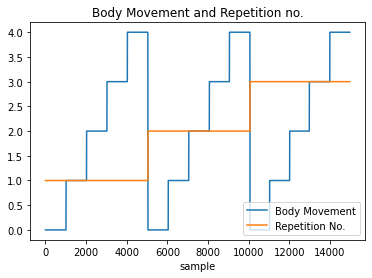

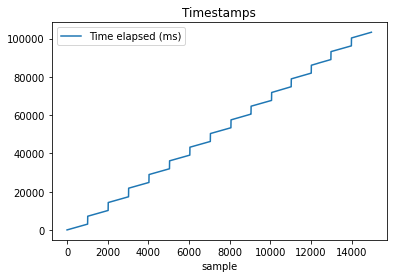

In [64]:
plot_body_rep(data)
plot_timestamps(data)

My next step was to split the data into windows by identifying the discontinuities in the timestamps via the window_split() function. 

**Note:** I originally split the data using timestamps as shown here. However, the way this data set is structure it would be easy to filter the data on body position and repetition no. to achieve the same result. Ultimately the more robust method would depend on data collection procedure and the resulting data structure.

In [65]:
windows=window_split(data)

To dive a little deeper into each window, I tried rotating the acceleration data into the global WSU reference frame using the quaternions. Finding roughly the appropriate orientation of gravity at the beginning of each window lends support to the assumption that the accelerometer and gyro data are in the local device ENU coordinate frame, while the quaternions track the relative orientation to the global WSU reference frame. From this I was able to learn there exists a relative quiet period at the beginning of each window, meaning the user is generally stationary prior to being prompted. I tried using this transformed acceleration data to calculate the device's position and velocity relative to the beginning of each window, with eventual clustering based on euclidian distance in mind. A few potential problems with this approach that are immediately apparent are the user's potential orientation and body movements driving similarities between windows, rather than wrist motion. These challenges are present with many of my attempted classification methods, which will be addressed further in that section of this report. While initial inspection of the rotated acceleration data shows roughly the expected (0, 0, -9.8)  m/s^2 (W, S, U), limitations of the device's orientation tracking make navigating via the acceleration data in this way difficult. For example, in window 15 the early rotated acceleration data reads roughly (3, 4.2, -8.2)  m/s^2 (W,S,U), suggesting a significant error in the orientation tracking. Position tracking with this simple method in euclidian space suffers as a result of this.

The functions in the cell below execute the tasks described above, with examples plotted limited to 3 windows (#2-4) for brevity within this report.

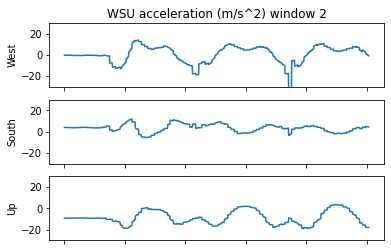

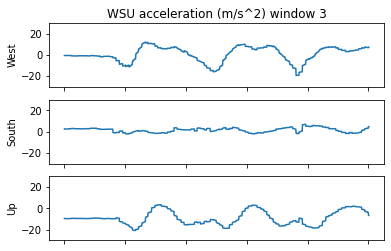

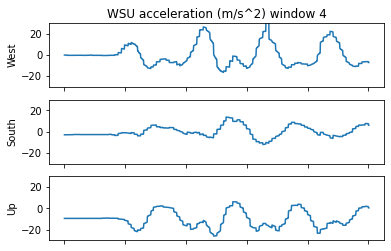

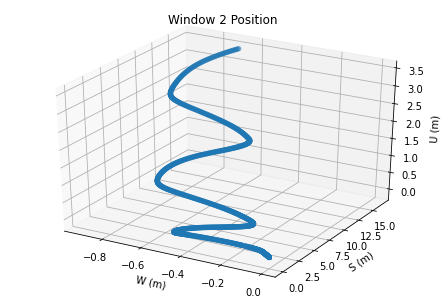

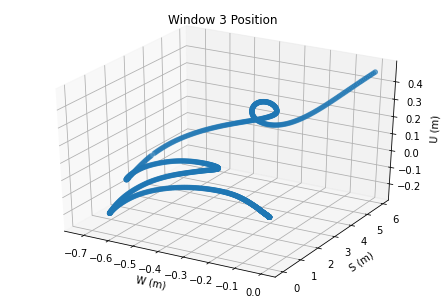

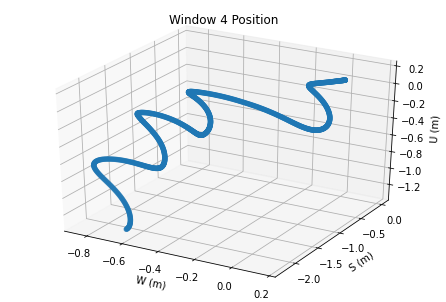

In [66]:
nav=window_nav(windows)
plot_accel_ref(nav)
plot_window_nav(nav)

Next, in an attempt to transform the data into user orientation agnostic metrics that capture the gestures in each window, I tried tracking the relative orientation changes in each window, and applying those orientations to a set of 3 orthogonal vectors in euclidean space. The following two steps are executed in the cell below.

1.   With the window_orient() function, rotate the quaternions in each window by the inverse of the initial quaternion, transforming the time series orientations to be relative to the initial orientation of the given window rather than the reference WSU coordinate frame
2.   Apply the resulting orientations to a set of 3 points representing unit vectors in the X, Y, and Z directions usig the frame_trace() function. This results in a time series representation of a reference frame on the device relative to the initial orientation for a given window.



In [67]:
att_track=window_orient(windows)
frame_traces=frame_trace(att_track)

At this point, I felt I was focusing too heavily on the quaternion orientation tracking. Admittedly, my attention was drawn there because it's a relatively new subject to me, my previous IMU experience being with sensor characterization and calibration in laboratory environments where the eventual application is on a gimballed inertially stabilized platform. Since I'm interested in using the relative motion in the device reference frame to classify wrist motion, working with the inertial sensors output directly should be a simpler way to characterize that motion. To that end I calculated the accumulated angle in each of the gyro axes across each window, the thought being that the device will accumulate similiar angle about each axis when going through a similar wrist motion, with less impact on accumulated angle from periodic inputs driven by the user's gait. The results are ploted below for windows 5, 10, and 15, which are the windows where the user is running.

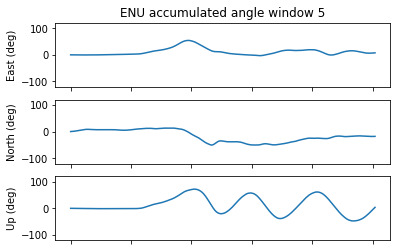

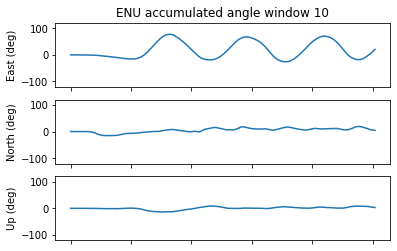

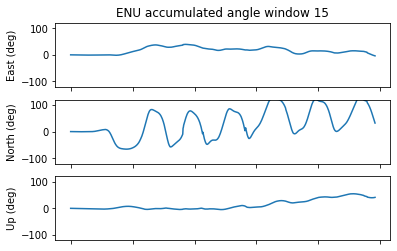

In [68]:
ang=ang_accum(windows)
plot_ang_accum(ang)

The obvious pattern shown above is consistent across the first 5, second 5 and third 5 windows. In the first 5 windows, the dominant periodic signal in accumulated angle is in the Up axis. It's in the East axis for the second 5 windows and the North axis for the 3rd five windows. It should be noted here that this calls into question the assumptions I've made up to this point, because I can think of no reason for the accumulated angle behavior to switch axes in the device reference frame in this way given my assumptions about what each window represents, gesture repetitions and the reference frame definitions. Additionally, here and elsewhere I've noted that the final 5 windows seem to have relatively more motion than earlier windows, lending support to the interpretation that "repetition no." refers to the number of times a gesture is repeated during a given window. This interpretation seems directly contradictory to the information in the problem statement, so I continue with my original assumptions.

The final aspect of the data that requires attention is the ADC counts. Pison devices are not meant to classify wrist motion and gestures through IMU data alone. My assumption is that channel 0 and channel 1 are independent measures of the electric field in the users wrist, potentially in different locations. The 4 columns tracking channel 0 and channel 1 through the first data collection window are plotted below to facilitate discussion.

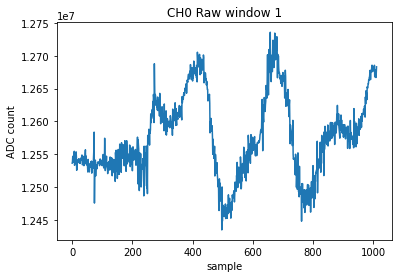

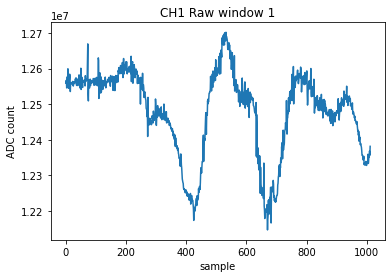

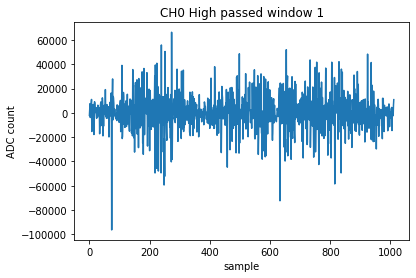

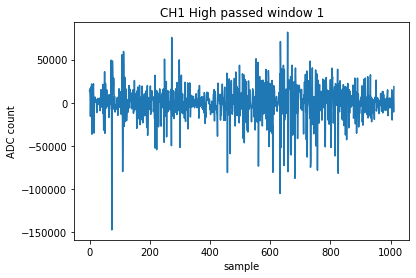

In [69]:
plot_ex_ADC(windows)

The existence of the high pass filtered data suggests its usefulness in classification, however much of the structure on the timescale that I would expect to be relevant to gestures and wrist motion is wiped out. A plausible explanation could be that the electrical signals relevant to wrist motion classification are higher frequency, and the high passed ADC counts in conjunction with the IMU data will be most useful when we get to classification attempts.

In order to reduce the noise in the high passed signal and create a signal that lends itself to dynamic time warping (which will be used in classification) I used a median filter as demonstrated with window 8 channel 0 below.

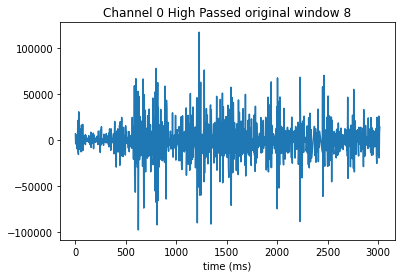

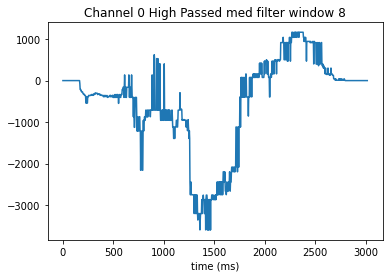

In [70]:
plot_window8_medfilt(windows, 3)

Throughout this process, I experimented with various other signal processing and clustering techniques. I attempted some processing with continuous wavelet transformations (mostly because of the mention in the job description), ffts, and binned integration to turn the time series data into manageable feature vectors for clustering. The functions written to explore these techniques which were ultimately not used in classification or discussed in the report have been moved to the appendix.

# Classification
From the inferences made in the data exploration section, we can make some modifications to our classification task. Since we've now assumed there are 5 classes, each occuring once in the first 5, second 5 and third 5 windows, we can assign the labels 1-5 to the first 5 windows. The task now becomes identifying when each of these 5 gestures is repeated. We know that each will be repeated once in the second 5 windows, and once again in the final set of 5 windows. Given that we now have some classified data in the first 5 windows, it's tempting to begin thinking of this task in a supervised learning format, however with only one instance of each class labeled, I continue using unsupervised approaches to classify the data within the constraints applied earlier.

Clustering time series data is a difficult task with many potential approaches, and given the constraints, this task does not easily lend itself to readily available clustering functions I'm familiar with. The approach I took utilizes dynamic time warping on the median filtered high passed ADC counts and relative orientation traces to get a measure of similarity between our default cluster representatives (1-5) and the remaining windows.  For each window 6-15 I use an implementation of the softmax function to translate these similarity measures into probabilities that the window belongs to the same class as each representative. Finally, I look for the five clusters that maximize these probabilities while selecting 1 window from each of the three sets of five. This is represented by 5 sets of 2 windows. Each set represents the one window from 6-10 and one window from 11-15 that have the highest probability of belonging to each of the 5 representative windows.

In [71]:
frame_trace_dtw=trace_dtw_matrix(frame_traces)
ADC_hp_dtw=ADC_dtw_matrix(windows)

class_probs=softmax_dtw_arrays(frame_trace_dtw,ADC_hp_dtw)

clusters=max_prob(class_probs)

print(clusters)

[[9, 13], [7, 12], [8, 14], [6, 15], [6, 15]]


The only conflict occurs between the best matches with windows 4 and 5. Window 4 had the better match in both cases and takes precedence. With this approach, the following classifications result:

Windows [1 , 9 , 13] classified as wrist motion 1

Windows [2 , 7 , 12] classified as wrist motion 2

Windows [3 , 8 , 14] classified as wrist motion 3

Windows [4 , 6 , 15] classified as wrist motion 4

Windows [5 , 10 , 11] classified as wrist motion 5


Quantifying the generalization performance of my classifier is difficult without more data. I could in a sense quantify the performance by measuring how well the different classifications for windows 6-15 were differentiated, however I did not have time to explore this. I also did not have time to attempt to identify the 5 wrist motion classes.

As noted in the data explorations section, the interpretation of body movement, repetition number, and prompting window as referred to in the problem statement had a significant impact on the approach taken.

# Appendix

In [72]:
""" Unused utilities """

def ADC_ffts(windows):
    """ Obtain fft of ADC count rate in count/s"""
    ADC_fft=[]
    for i in range(len(windows)):
        N=len(windows[i][:,1]-1)
        """ assumes uniform time step of 3 ms"""
        T=0.003
        xf = fft.fftfreq(N, T)[:N//2]
        ch0raw=fft.fft(np.diff(windows[i][:,1])/T)
        ch0hp=fft.fft(np.diff(windows[i][:,3])/T)
        ch1raw=fft.fft(np.diff(windows[i][:,2])/T)
        ch1hp=fft.fft(np.diff(windows[i][:,4])/T)
        temp=np.column_stack((xf,ch0raw[0:N//2],ch1raw[0:N//2]))
        # temp=np.column_stack((xf,ch0raw[0:N//2],ch0hp[0:N//2],ch1raw[0:N//2],ch1hp[0:N//2]))
        ADC_fft.append(temp)
        # plt.figure()
        # plt.plot(xf, 2.0/N * np.abs(ch0raw[0:N//2]))
        # plt.grid()
        # plt.show()
        # input("press enter to continue")
        # plt.close()
    return ADC_fft

def Rate_ffts(windows):
    Rate_fft=[]
    for i in range(len(windows)):
        N=len(windows[i][:,1])
        T=0.003
        xf = fft.fftfreq(N, T)[:N//2]
        X_rate=fft.fft(windows[i][:,9])
        Y_rate=fft.fft(windows[i][:,10])
        Z_rate=fft.fft(windows[i][:,11])

        temp=np.column_stack((xf,X_rate[0:N//2],Y_rate[0:N//2],Z_rate[0:N//2]))
        Rate_fft.append(temp)
    return Rate_fft

def Accel_ffts(windows):
    Accel_fft=[]
    for i in range(len(windows)):
        N=len(windows[i][:,1])
        T=0.003
        xf = fft.fftfreq(N, T)[:N//2]
        X_accel=fft.fft(windows[i][:,12])
        Y_accel=fft.fft(windows[i][:,13])
        Z_accel=fft.fft(windows[i][:,14])
        temp=np.column_stack((xf,X_accel[0:N//2],Y_accel[0:N//2],Z_accel[0:N//2]))
        Accel_fft.append(temp)
    return Accel_fft

def cwt_features(windows, cols, widths):
    cwt_features=[]
    lengths=np.zeros(len(windows))
    widths=np.arange(1,widths)
    for i in range(len(windows)):
        lengths[i]=len(windows[i][:,0])
    minlength=int(min(lengths))  
    for i in range(len(windows)):
        temp=[]
        for ii in range(len(cols)):
            temp.append(signal.cwt(windows[i][:minlength,cols[ii]],signal.ricker,widths))
            plt.imshow(temp[ii], extent=[0, minlength, min(widths), max(widths)], cmap='PRGn', aspect='auto',
           vmax=abs(temp[ii][2:-2,100:-100]).max(), vmin=-abs(temp[ii][2:-2,100:-100]).max())
            plt.title(col_name(cols[ii])+' window '+str(i+1))
            plt.show()
        cwt_features.append(temp)
    return cwt_features

def integrated_fft_features(ffts,bins):
    lengths=np.zeros(len(ffts))
    for i in range(len(ffts)):
        lengths[i]=len(ffts[i][:,0])
    minlength=50  
    bin_width=int(np.floor(minlength/bins))
    features=np.empty((len(ffts),len(ffts[i][0,:])-1,bins))
    for i in range(len(ffts)):
        for ii in range(1,len(ffts[i][0,:])):
            for iii in range(1,bins):
                features[i,ii-1,iii]=np.trapz(abs(ffts[i][iii*bin_width:iii*bin_width+bin_width,ii]),abs(ffts[i][iii*bin_width:iii*bin_width+bin_width,0]))
    features=np.reshape(features,(len(ffts),bins*(len(ffts[i][0,:])-1)))
    return features
    
def col_name(col_index):
    """ Returns column name """
    col_names=['timestamp (ms)','Channel0 Raw','Channel1 Raw','Channel 0 High Passed','Channel 1 High Passed','Quaternion X','Quaternion Y','Quaternion Z', 'Quaternion W', 'Rate X', 'Rate Y','Rate Z','Accel X','Accel Y','Accel Z','Body Position','Repetition Number']
    return col_names[col_index]

def plot_all_windows(windows, col_index):
    """ Plots all 15 prompting windows for the given column"""
    for i in range(len(windows)):
        plt.figure()
        plt.plot(windows[i][:,col_index])
        if 5<=col_index<=8:
            matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-1,top=1)
        plt.title(col_name(col_index)+' window '+str(i+1))
        plt.xlabel('sample')
    
   
def plot_all_windows_medfilt(windows, col_index, kernel_size=3):
    """ Plots all 15 prompting windows w/ median filter"""
    for i in range(len(windows)):
        plt.figure()
        plt.plot(windows[i][:-1,0]-windows[i][0,0],signal.medfilt(np.diff(windows[i][:,col_index]),kernel_size))
        if 5<=col_index<=8:
            matplotlib.axes.Axes.set_ylim(plt.gca(),bottom=-1,top=1)
        
        plt.title(col_name(col_index)+' window '+str(i+1))
        plt.xlabel('time (ms)')    
    
def integrated_highpass_features(windows,bins):
    lengths=np.zeros(len(windows))
    for i in range(len(windows)):
        lengths[i]=len(windows[i][:,0])
    minlength=min(lengths)  
    bin_width=int(np.floor(minlength/bins))
    features=np.empty((len(windows),2,bins))
    for i in range(len(windows)):
        for ii in [3,4]:
            for iii in range(bins):
                features[i,ii-3,iii]=np.trapz(windows[i][iii*bin_width:iii*bin_width+bin_width,ii],windows[i][iii*bin_width:iii*bin_width+bin_width,0])
            features[i,ii-3,:]=features[i,ii-3,:]/np.sum(abs(features[i,ii-3,:]))
            print(np.sum(features[i,ii-3,:]))
    features=np.reshape(features,(len(windows),bins*2))
    return features    
    
def Quat_dtw_matrix(windows):
    Quat_dtw=np.zeros((10,5))
    for i in range(5,len(windows)):
        for ii in range(5):
            Quat_dtw[i-5,ii]=metrics.dtw(windows[ii][:,7],windows[i][:,7])
    return Quat_dtw    
